# Rationale Model

### Hyperparameters

In [1]:
max_sentlen, max_doclen = 3, 2
word_dim, vocab_size = 5, 10
nb_filter, filter_len = 16, 1

nb_class = 2

### Define Model

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 6)             0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 6, 5)          50          input_2[0][0]                    
____________________________________________________________________________________________________
reshape_4 (Reshape)              (None, 1, 3, 10)      0           embedding_2[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 3, 2)      96          reshape_4[0][0]                  
___________________________________________________________________________________________

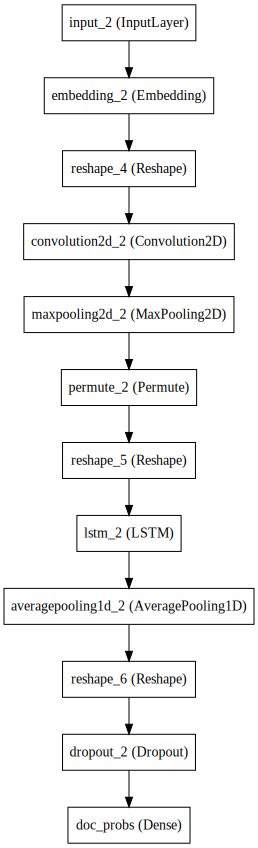

In [4]:
from keras.layers import Input, Embedding, Dense, Reshape, Permute, Dropout
from keras.layers import Convolution2D, MaxPooling2D, Flatten, LSTM, AveragePooling1D
from keras.models import Model
from keras.layers import TimeDistributed

input = Input(shape=[max_sentlen*max_doclen], dtype='int32')

embedded = Embedding(output_dim=word_dim, input_dim=vocab_size, input_length=max_sentlen*max_doclen)(input)
reshaped = Reshape([1, max_sentlen, word_dim*max_doclen])(embedded)
convolved = Convolution2D(nb_filter, nb_row=filter_len, nb_col=word_dim, subsample=[1, word_dim])(reshaped)
pooled = MaxPooling2D(pool_size=[max_sentlen-filter_len+1, 1])(convolved)
permuted = Permute([2, 3, 1])(pooled)
activations = Reshape([max_doclen, nb_filter])(permuted)
hiddens = LSTM(output_dim=nb_filter, return_sequences=True)(activations)
sent_probs = TimeDistributed(Dense(output_dim=3))(hiddens) # just for illustration purposed
collapsed = AveragePooling1D(pool_length=max_doclen)(hiddens)
hidden = Reshape([nb_filter])(collapsed)
hidden = Dropout(0.5)(hidden)
doc_probs = Dense(output_dim=nb_class, activation='softmax', name='doc_probs')(hidden)

model = Model(input=input, output=doc_probs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train Model

In [7]:
from keras.utils.np_utils import to_categorical

nb_train = 2

X = np.zeros([nb_train, max_sentlen*max_doclen])
X[0], X[1] = np.array([1, 2, 1] + [0, 1, 0]), np.array([0, 1, 0] + [1, 2, 1])

y = to_categorical([1, 0])

model.fit(X, y)

Epoch 1/10
2/2 [==============================] - 0s - loss: 0.6911 - acc: 1.0000
Epoch 2/10
2/2 [==============================] - 0s - loss: 0.6933 - acc: 0.5000
Epoch 3/10
2/2 [==============================] - 0s - loss: 0.6939 - acc: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 0s - loss: 0.6921 - acc: 1.0000
Epoch 5/10
2/2 [==============================] - 0s - loss: 0.6943 - acc: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 0s - loss: 0.6923 - acc: 1.0000
Epoch 7/10
2/2 [==============================] - 0s - loss: 0.6929 - acc: 0.5000
Epoch 8/10
2/2 [==============================] - 0s - loss: 0.6924 - acc: 0.5000
Epoch 9/10
2/2 [==============================] - 0s - loss: 0.6944 - acc: 0.0000e+00
Epoch 10/10
2/2 [==============================] - 0s - loss: 0.6922 - acc: 1.0000


### Predict

In [32]:
import keras.backend as K

f = K.function(inputs=model.inputs+[K.learning_phase()],
               outputs=[sent_probs, model.get_layer('doc_probs').output])

[output[0] for output in f([X, 1])] # only grab the result from the first document

[array([[ 0.00231019,  0.00555932,  0.00022178],
        [-0.00690298, -0.00216747,  0.00016243]], dtype=float32),
 array([ 0.49855483,  0.50144517], dtype=float32)]